In [1]:
from witch.core import model
from witch.utils import *
from witch.fitter import *
from witch.containers import Model
import witch.mapmaking as mm
from witch.structure import a10, ea10

import minkasi.tools.presets_by_source as pbs
import minkasi

from astropy.coordinates import Angle
import astropy.units as units

import yaml
import numpy as np
import os
import glob
import shutil

from scipy.integrate import trapz

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

mpi4py imported
nproc:,  1


In [2]:
def int_3d(func, xyz, r1, r2, r3, r500):
    x0 = np.mean([model_ea10.xyz[0][0], model_ea10.xyz[0][-1]])
    y0 = np.mean([model_ea10.xyz[1][0][0], model_ea10.xyz[1][0][-1]])
    x = model_ea10.xyz[0][:,0,0]-x0
    y = model_ea10.xyz[1][0,:,0]-y0
    z = model_ea10.xyz[2][0,0,:]

    norm = (r1*r2*r3)**(1/3)
    r1 *= r500/norm
    r2 *= r500/norm
    r3 *= r500/norm

    X, Y, Z = np.meshgrid(x/r2, y/r1, z/r3) #Note x/y are backwards from whats in grid so swap here
    flags = np.where((np.sqrt(X**2 + Y**2 + Z**2)<=1), func, np.zeros(func.shape))
    return flags

In [3]:

path = "/home/jorlo/dev/minkasi_jax/configs/ea10_sims/ea10_sim.yaml"
with open(path, "r") as file:
    cfg = yaml.safe_load(file)
if "models" not in cfg:
    cfg["models"] = {}
fit = True

In [4]:
cfg = load_config({}, path)
cfg["fit"] = cfg.get("fit", "model" in cfg)
cfg["sim"] = cfg.get("sim", False)
cfg["wnoise"] = cfg.get("wnoise", False)
cfg["map"] = cfg.get("map", True)
cfg["sub"] = cfg.get("sub", True)

# Get TODs
todvec = load_tods(cfg)

# make a template map with desired pixel size an limits that cover the data
# todvec.lims() is MPI-aware and will return global limits, not just
# the ones from private TODs
lims = todvec.lims()
pixsize = cfg.get("pix_size", 2.0 / wu.rad_to_arcsec)
skymap = minkasi.maps.SkyMap(lims, pixsize)

# Define the model and get stuff setup for minkasi
model = Model.from_cfg(cfg, pix_size=pixsize, lims=lims)
funs = [model.minkasi_helper]
params = np.array(model.pars)
npars = np.array([len(params)])
prior_vals = model.priors
priors = [None if prior is None else "flat" for prior in prior_vals]

# Deal with bowling and simming in TODs and setup noise
noise_class = eval(str(cfg["minkasi"]["noise"]["class"]))
noise_args = eval(str(cfg["minkasi"]["noise"]["args"]))
noise_kwargs = eval(str(cfg["minkasi"]["noise"]["kwargs"]))
bowl_str = process_tods(
    cfg, todvec, skymap, noise_class, noise_args, noise_kwargs, model
)

# Get output
if "base" in cfg.keys():
    del cfg["base"]  # We've collated to the cfg files so no need to keep the base
outdir = get_outdir(cfg, bowl_str, model)

# Make signal maps
if cfg.get("sig_map", cfg.get("map", True)):
    print_once("Making signal map")
    mm.make_maps(
        todvec,
        skymap,
        noise_class,
        noise_args,
        noise_kwargs,
        os.path.join(outdir, "signal"),
        cfg["minkasi"]["npass"],
        cfg["minkasi"]["dograd"],
    )
else:
    print_once(
        "Not making signal map, this means that your starting noise may be more off"
    )
if cfg["sim"] and cfg["fit"]:
    #Remove structs we deliberately want to leave out of model
    for struct_name in cfg["model"]["structures"]:
        if cfg["model"]["structures"][struct_name].get("to_remove", False):
            model.remove_struct(struct_name)
    params = np.array(model.pars)
    npars = np.array([len(params)])
    prior_vals = model.priors
    priors = [None if prior is None else "flat" for prior in prior_vals]
    params[model.to_fit_ever] *= 1.1  # Don't start at exactly the right value
    model.update(params, model.errs, model.chisq)

deleted  0  bad files.
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
ndata and ndet are  72 23691 72  on  /mnt/welch/MUSTANG/M2-TODs/RXJ1347/Signal_TOD-AGBT16A_473_02-s134.fits with lims  206.7930066322188 206.9415359259099 -11.834223958811396 -11.67501907944757
truncating from  23691  to  23626
truncating from  2362  to  2353
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
ndata and ndet are  76 9219 76  on  /mnt/welch/MUSTANG/M2-TODs/RXJ1347/Signal_TOD-AGBT16A_473_02-s135.fits with lims  206.79441365118782 206.9250205284968 -11.828844331066366 -11.675085673791976
truncating from  9219  to  9217
truncating from  921  to  901
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 93

In [5]:
model_ea10 = model
grid_ea10 = ea10(*model_ea10.pars, model_ea10.xyz)
nz = get_nz(model_ea10.pars[-1])
da = get_da(model_ea10.pars[-1])
m500 = model_ea10.pars[9]
r500 = (m500 / (4.00 * np.pi / 3.00) / 5.00e02 / nz) ** (1.00 / 3.00)
ea10_out = int_3d(grid_ea10, model_ea10.xyz, 12, 7, 9.5, r500/da)


84557.72973827981


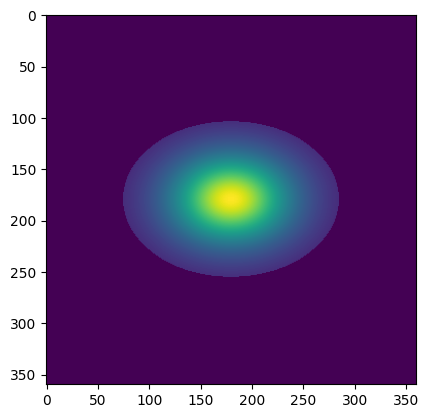

In [6]:
plt.imshow(ea10_out[120])
print(np.sum(ea10_out))

In [7]:

path = "/home/jorlo/dev/minkasi_jax/configs/ea10_sims/a10_sim.yaml"
with open(path, "r") as file:
    cfg = yaml.safe_load(file)
if "models" not in cfg:
    cfg["models"] = {}
fit = True
cfg = load_config({}, path)
cfg["fit"] = cfg.get("fit", "model" in cfg)
cfg["sim"] = cfg.get("sim", False)
cfg["wnoise"] = cfg.get("wnoise", False)
cfg["map"] = cfg.get("map", True)
cfg["sub"] = cfg.get("sub", True)

# Get TODs
todvec = load_tods(cfg)

# make a template map with desired pixel size an limits that cover the data
# todvec.lims() is MPI-aware and will return global limits, not just
# the ones from private TODs
lims = todvec.lims()
pixsize = cfg.get("pix_size", 2.0 / wu.rad_to_arcsec)
skymap = minkasi.maps.SkyMap(lims, pixsize)

# Define the model and get stuff setup for minkasi
model = Model.from_cfg(cfg, pix_size=pixsize, lims=lims)
funs = [model.minkasi_helper]
params = np.array(model.pars)
npars = np.array([len(params)])
prior_vals = model.priors
priors = [None if prior is None else "flat" for prior in prior_vals]

# Deal with bowling and simming in TODs and setup noise
noise_class = eval(str(cfg["minkasi"]["noise"]["class"]))
noise_args = eval(str(cfg["minkasi"]["noise"]["args"]))
noise_kwargs = eval(str(cfg["minkasi"]["noise"]["kwargs"]))
bowl_str = process_tods(
    cfg, todvec, skymap, noise_class, noise_args, noise_kwargs, model
)

# Get output
if "base" in cfg.keys():
    del cfg["base"]  # We've collated to the cfg files so no need to keep the base
outdir = get_outdir(cfg, bowl_str, model)

# Make signal maps
if cfg.get("sig_map", cfg.get("map", True)):
    print_once("Making signal map")
    mm.make_maps(
        todvec,
        skymap,
        noise_class,
        noise_args,
        noise_kwargs,
        os.path.join(outdir, "signal"),
        cfg["minkasi"]["npass"],
        cfg["minkasi"]["dograd"],
    )
else:
    print_once(
        "Not making signal map, this means that your starting noise may be more off"
    )
if cfg["sim"] and cfg["fit"]:
    #Remove structs we deliberately want to leave out of model
    for struct_name in cfg["model"]["structures"]:
        if cfg["model"]["structures"][struct_name].get("to_remove", False):
            model.remove_struct(struct_name)
    params = np.array(model.pars)
    npars = np.array([len(params)])
    prior_vals = model.priors
    priors = [None if prior is None else "flat" for prior in prior_vals]
    params[model.to_fit_ever] *= 1.1  # Don't start at exactly the right value
    model.update(params, model.errs, model.chisq)

deleted  0  bad files.
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
ndata and ndet are  72 23691 72  on  /mnt/welch/MUSTANG/M2-TODs/RXJ1347/Signal_TOD-AGBT16A_473_02-s134.fits with lims  206.7930066322188 206.9415359259099 -11.834223958811396 -11.67501907944757
truncating from  23691  to  23626
truncating from  2362  to  2353
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
ndata and ndet are  76 9219 76  on  /mnt/welch/MUSTANG/M2-TODs/RXJ1347/Signal_TOD-AGBT16A_473_02-s135.fits with lims  206.79441365118782 206.9250205284968 -11.828844331066366 -11.675085673791976
truncating from  9219  to  9217
truncating from  921  to  901
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 93

In [8]:
model_a10 = model
grid_a10 = a10(*model_a10.pars, model_a10.xyz)
nz = get_nz(model_a10.pars[-1])
da = get_da(model_a10.pars[-1])
m500 = model_a10.pars[6]
r500 = (m500 / (4.00 * np.pi / 3.00) / 5.00e02 / nz) ** (1.00 / 3.00)
a10_out = int_3d(grid_a10, model_a10.xyz, 1, 1, 1, r500/da)

84558.12089593052


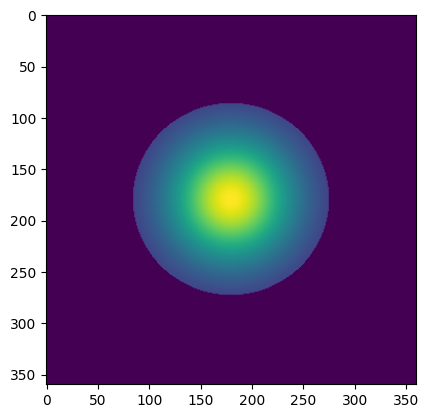

In [9]:
plt.imshow(a10_out[120])
print(np.sum(a10_out))